# Emotional Dialogues Project

Participants: 
- Rachel Kim
- Igor Katselenbogen
- Filippo Manzardo

Describe what we do...

## What is given?

Dataset: The dataset consist of short conversation passages (of 3 to 5 utterances each), each labelled with an emotion.
- Task: The original task on this dataset was to generate responses in the dialogue that respect the target emotion, but the dataset could also be used for sentiment analysis: i.e. to identify the emotion associated with each utterance in the dialogue.
- Hints and suggestions: You could apply various classifiers for the sentiment analysis task including Transformer based models like BERT. Does knowing the previous (or subsequent) utterance improve the classifier performance? Note also that we will demonstrate text generation techniques in the latter practical sessions of the course.


## The task

The aim of the assignment is to apply the techniques you have learnt in class to analyse one of the text datasets described below. The exact tasks performed may depend on the dataset chosen, but we would expect to see some of the following:
### 1. Preliminary analysis:
Briefly describe the dataset:
- what type of documents does it contain?
- how many documents are there?
- calculate and visualise some simple statistics for the collection, e.g. the average document
length, the average vocabulary size, etc.
Play around with documents, using some of the code from the early parts of the course. You could, for example:
- cluster the documents and visualise the clusters to see what types of groups are present (or whether the known classes can be found);
- index the documents so that you can perform keyword search over them;
- train a Word2Vec embedding on the data and investigate the properties of the resulting
embedding.
   
### 2. Training models:
Each of the datasets comes with a particular task that you need to perform, so:
- train a model to perform that task (by fine-tuning models on the training data);
- test pre-trained models on the task (if they already exist); and
- evaluate different models and compare their performance.
HINT: as a minimum here we would expect to see a linear classifier trained on the data (if an appropriate for the task) and compare it with deep learning model, such as BERT.

### 3. Possible extensions:
Depending on the dataset chosen there will be many additional investigations you can perform. For instance, oftentimes we can improve performance of a model on a particular task by simply including additional data that is related to the task in its training set. So see if you can find other data that helps with the task that you chose. Moreover, there are many NLP challenges out there, so if you can’t find more data for the task you’re working on, look for another interesting challenge to work on.

### Reasonings between the team

Overall we should:
- setup everything, so we can actually see the data ⚙️
- provide analysis of the data
- clean the data
- try to train the model for the answer generation
- try to also train the classifier (which sentiment does it contains)
- try to find some insights and maybe propose what could we do with the data

## Prepare environment

Please use Python `< 3.11`, this notebook was run using Python `3.10.3`

In [33]:
%pip install pandas seaborn matplotlib transformers scikit-learn ktrain

# Install tensorflow-metal if environment uses Apple Silicon
import os
if os.uname().machine == 'arm64':
    %pip install tensorflow-macos tensorflow-metal
else:
    %pip install tensorflow


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 24.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 21.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 25.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 KB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached chardet-5.1.0-py3-none-any.whl (199 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.3 MB/s 

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
import tensorflow as tf
import re
import string
import transformers
import ktrain
import numpy as np
import sklearn

## Data prepration

As usual we start from data prepration.

Before starting We need to connect the Google Drive storage to the notebook.

##  Data loading
First thing we need to do is load a set of documents that we can cluster.

TODO: Write about the dataset

In [73]:
dataset_url = 'https://drive.google.com/u/0/uc?id=1AqxpBMFVDX-hUGA-treA8ffnSdyu0ggJ&export=download&confirm=t&uuid=a9c55950-657f-4984-adfd-368ac09e153e&at=AKKF8vyKSfG7CIDYm5OxPgCkteAp:1682881890156'
url = requests.get(dataset_url)
csv_raw = StringIO(url.text)
df = pd.read_csv(dataset_url)

print(f"Downloaded dataset with {df.shape[0]} rows and {df.shape[1]} columns, from {dataset_url}")

Downloaded dataset with 2829426 rows and 5 columns, from https://drive.google.com/u/0/uc?id=1AqxpBMFVDX-hUGA-treA8ffnSdyu0ggJ&export=download&confirm=t&uuid=a9c55950-657f-4984-adfd-368ac09e153e&at=AKKF8vyKSfG7CIDYm5OxPgCkteAp:1682881890156


## Data analysis

Let's go over some basic information about the data and analize it a bit together. 

In [4]:
df.head()

,dialogue_id,turn,uttr,eb+_emot,label_confidence
0,97,1,You moron ! What fool washes diapers by the we...,angry,0.437522
1,97,2,You useless fool !,furious,0.731564
2,99,1,How dare you sleep !,furious,0.605636
3,99,2,Up ! Go and clean the house .,prepared,0.650449
4,100,1,Clean the kitchen .,prepared,0.742187


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829426 entries, 0 to 2829425
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dialogue_id       int64  
 1   turn              int64  
 2   uttr              object 
 3   eb+_emot          object 
 4   label_confidence  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 107.9+ MB


In [6]:
df.describe()

,dialogue_id,turn,label_confidence
count,2.829426e+06,2.829426e+06,2.829426e+06
mean,4.412749e+06,2.175293e+00,7.299294e-01
std,2.546941e+06,1.278257e+00,1.826976e-01
min,1.000000e+00,1.000000e+00,4.240134e-01
25%,2.209518e+06,1.000000e+00,5.608567e-01
50%,4.413634e+06,2.000000e+00,7.352417e-01
75%,6.616340e+06,3.000000e+00,9.074353e-01
max,8.820637e+06,1.400000e+01,9.995806e-01


First thing we could say is that we have **2 829 426** entries in our dataset and **5** columns. 

Let's go over the columns and see a bit closer what each of them mean:

*   dialogue_id — an identificator of the dialogue. It would be helpful for us, 
*   turn —
*   uttr — 
*   label_confidence —
*   eb+_emot —

The target column for our purposes is eb+_emot. Let's see a bit more about the values in there:

In [7]:
# Find unique words in `uttr` column, it contains a string so we need to split it first
count = df['uttr'].str.split(expand=True).stack().value_counts()


print(f"Unique words in `uttr` column: {len(count)}")
print(f"Total words count: {count.sum()}")

Unique words in `uttr` column: 328076
Total words count: 39469825


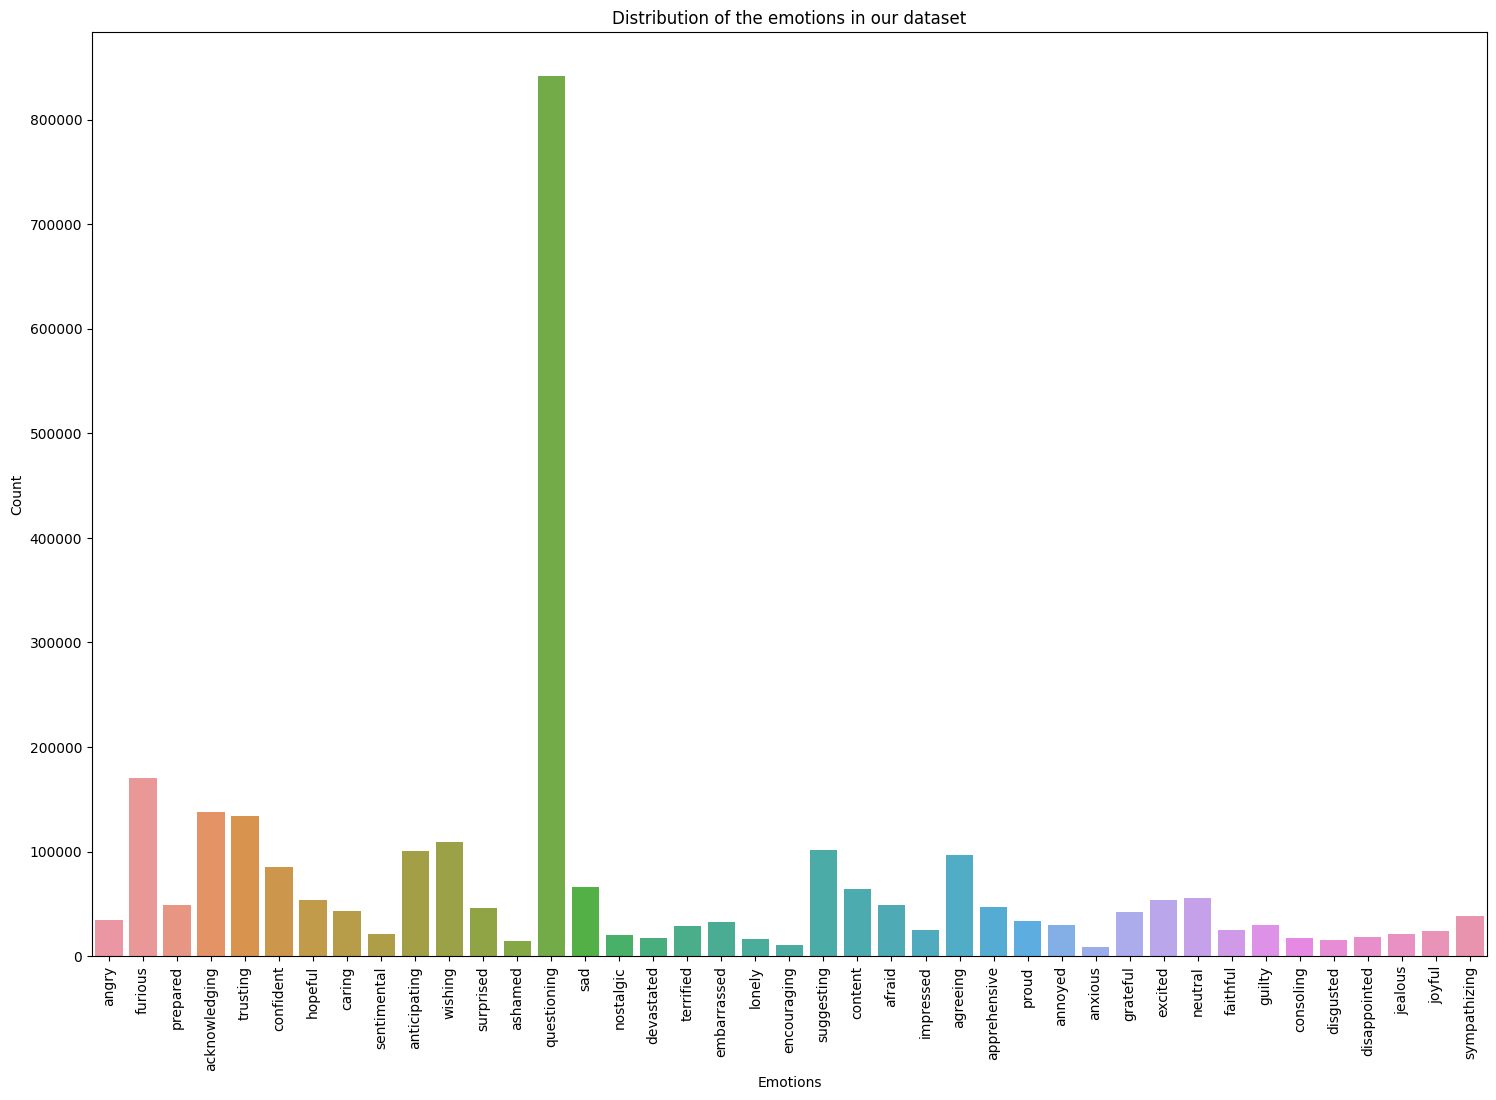

In [8]:
plt.figure(figsize=(18, 12))
sns.countplot(data=df, x='eb+_emot')

plt.title('Distribution of the emotions in our dataset')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.show()

We can see that the emotions aren't distributed proportionally. There is clear disbalance: most of the entries have questioning emotions. That is normal in real datasets, but it just simply means that we need to account it in our work.

In [74]:
# Take an equel nuber of samples based on the least represented emotion
min_count = df['eb+_emot'].value_counts().min()
df_reduced = df.groupby('eb+_emot').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# Split train and test data
train, test = train_test_split(df_reduced, test_size=0.2, random_state=42)
label_to_id = {
    label: index
    for index, label in enumerate(train['eb+_emot'].unique())
}


print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")

Train dataset shape: (281358, 5)
Test dataset shape: (70340, 5)


In [75]:
#Use regex to clean the data
def remove_url(text: str) -> str:
    """Remove URLs from a string"""
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text: str) -> str:
    """Remove punctuation from a string"""
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text: str) -> str:
    """Remove html tags from a string"""
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text: str) -> str:
    """Remove emojis from a string"""
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text: str) -> str:
    """Decontraction helper"""
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text: str) -> str:
    """Seperate alphanumeric characters"""
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text: str) -> str:
    """Remove characters repeated more than twice in a row"""
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep: str, text: str) -> str:
    """Remove characters repeated more than twice in a row"""
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def label_to_idx(label: str):
    """Convert label to index, making labels into categorical numbers"""
    return label_to_id[label]



train['uttr'] = train['uttr'].apply(lambda x : remove_url(x))
train['uttr'] = train['uttr'].apply(lambda x : remove_punct(x))
train['uttr'] = train['uttr'].apply(lambda x : remove_emoji(x))
train['uttr'] = train['uttr'].apply(lambda x : decontraction(x))
train['uttr'] = train['uttr'].apply(lambda x : seperate_alphanumeric(x))
train['uttr'] = train['uttr'].apply(lambda x : unique_char(cont_rep_char,x))
train['eb+_emot'] = train['eb+_emot'].apply(lambda x : label_to_idx(x))

test['uttr'] = test['uttr'].apply(lambda x : remove_url(x))
test['uttr'] = test['uttr'].apply(lambda x : remove_punct(x))
test['uttr'] = test['uttr'].apply(lambda x : remove_emoji(x))
test['uttr'] = test['uttr'].apply(lambda x : decontraction(x))
test['uttr'] = test['uttr'].apply(lambda x : seperate_alphanumeric(x))
test['uttr'] = test['uttr'].apply(lambda x : unique_char(cont_rep_char,x))
test['eb+_emot'] = test['eb+_emot'].apply(lambda x : label_to_idx(x))

In [76]:
# Let's train a linear SVM classifier as a baseline model
# We will use TF-IDF to vectorize the text
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train['uttr'])
test_vectors = vectorizer.transform(test['uttr'])

classifier = sklearn.svm.LinearSVC()
classifier.fit(train_vectors, train['eb+_emot'])

# Predict on the test dataset
predictions = classifier.predict(test_vectors)

# Print the classification report
print(sklearn.metrics.classification_report(test['eb+_emot'], predictions))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59      1694
           1       0.60      0.60      0.60      1722
           2       0.65      0.70      0.67      1689
           3       0.59      0.65      0.62      1742
           4       0.73      0.83      0.78      1689
           5       0.54      0.50      0.52      1730
           6       0.54      0.54      0.54      1778
           7       0.49      0.50      0.49      1754
           8       0.66      0.66      0.66      1695
           9       0.42      0.36      0.39      1702
          10       0.45      0.38      0.41      1745
          11       0.48      0.50      0.49      1701
          12       0.54      0.46      0.49      1727
          13       0.35      0.35      0.35      1703
          14       0.51      0.51      0.51      1727
          15       0.53      0.59      0.56      1713
          16       0.55      0.52      0.54      1758
          17       0.68    

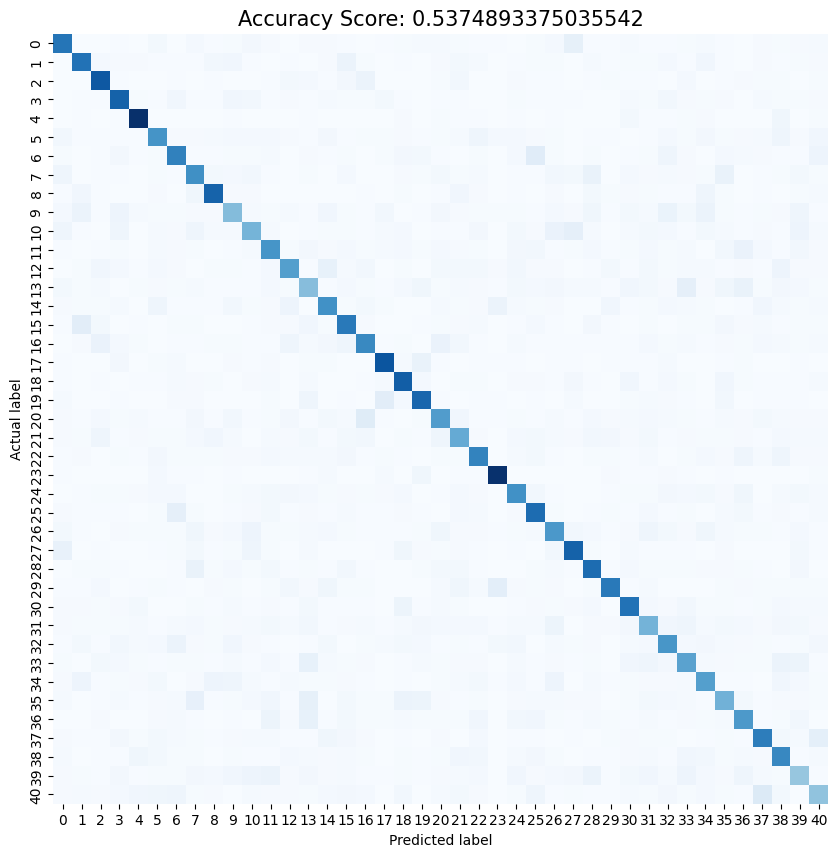

In [77]:
# Plot Confusion Matrix
cm = sklearn.metrics.confusion_matrix(test['eb+_emot'], predictions)
plt.figure(figsize=(10,10))
# No labels in the heatmap cause it messes up the plot
sns.heatmap(cm, cmap='Blues', cbar=False)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(sklearn.metrics.accuracy_score(test['eb+_emot'], predictions))
plt.title(all_sample_title, size = 15)
plt.show()

In [79]:
import sklearn.naive_bayes
# Let's try now with a naive bayes classifier
classifier = sklearn.naive_bayes.MultinomialNB()
classifier.fit(train_vectors, train['eb+_emot'])

# Predict on the test dataset
predictions = classifier.predict(test_vectors)

# Print the classification report
print(sklearn.metrics.classification_report(test['eb+_emot'], predictions))

              precision    recall  f1-score   support

           0       0.52      0.62      0.56      1694
           1       0.58      0.55      0.56      1722
           2       0.72      0.58      0.64      1689
           3       0.47      0.71      0.57      1742
           4       0.77      0.70      0.74      1689
           5       0.36      0.60      0.45      1730
           6       0.57      0.45      0.51      1778
           7       0.48      0.43      0.45      1754
           8       0.45      0.66      0.54      1695
           9       0.27      0.57      0.37      1702
          10       0.33      0.52      0.41      1745
          11       0.54      0.43      0.48      1701
          12       0.58      0.39      0.47      1727
          13       0.53      0.18      0.26      1703
          14       0.37      0.65      0.47      1727
          15       0.66      0.48      0.55      1713
          16       0.66      0.39      0.49      1758
          17       0.55    

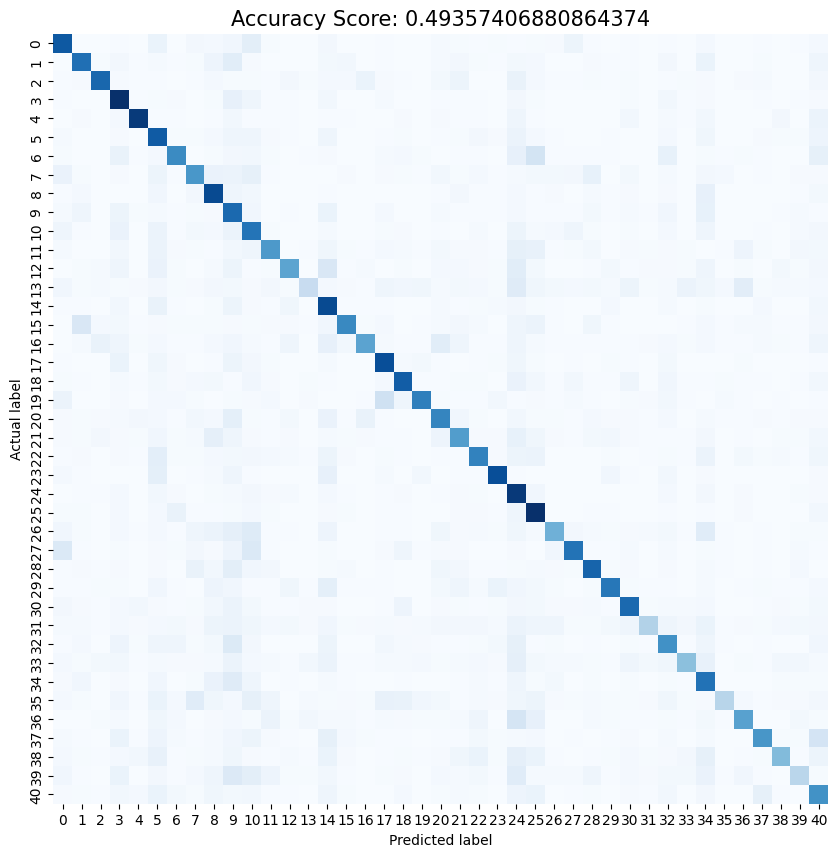

In [80]:
# Plot Confusion Matrix
cm = sklearn.metrics.confusion_matrix(test['eb+_emot'], predictions)
plt.figure(figsize=(10,10))
# No labels in the heatmap cause it messes up the plot
sns.heatmap(cm,  cmap='Blues', cbar=False)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(sklearn.metrics.accuracy_score(test['eb+_emot'], predictions))
plt.title(all_sample_title, size = 15)
plt.show()

Let's try now using a BERT model

In [86]:
# Smallest bert model
MODEL_NAME = 'distilroberta-base'
transformer = ktrain.text.Transformer(MODEL_NAME, maxlen=500, classes=df["eb+_emot"].unique().tolist())

# Shrink train and test data to 200 samples per class, too much for my laptop. Keep classes balanced
train_reduced = df.groupby('eb+_emot').apply(lambda x: x.sample(n=200, random_state=1)).reset_index(drop=True)
test_reduced = df.groupby('eb+_emot').apply(lambda x: x.sample(n=200, random_state=1)).reset_index(drop=True)

print("New train shape: ", train_reduced.shape)
print("New test shape: ", test_reduced.shape)

processed_train = transformer.preprocess_train(train_reduced['uttr'].to_list(), train_reduced['eb+_emot'].to_list())
processed_test = transformer.preprocess_test(test_reduced['uttr'].to_list(), test_reduced['eb+_emot'].to_list())

/Users/filippomanzardo/.pyenv/versions/3.10.3/lib/python3.10/site-packages/ktrain/text/preprocessor.py:382: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn(


New train shape:  (8200, 5)
New test shape:  (8200, 5)
preprocessing train...
language: en
train sequence lengths:
	mean : 17
	95percentile : 48
	99percentile : 69


/Users/filippomanzardo/.pyenv/versions/3.10.3/lib/python3.10/site-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 17
	95percentile : 48
	99percentile : 69


In [85]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=32)
learner.fit_onecycle(5e-5, 1)
learner.validate(class_names=transformer.get_classes())



begin training using onecycle policy with max lr of 5e-05...
 37/257 [===>..........................] - ETA: 19:27 - loss: 3.7161 - accuracy: 0.0270

KeyboardInterrupt: 